# Sentiment Classification for Movie Review Dataset (Korean)

본 핸즈온에서는 네이버 영화 리뷰에 대한 감정(0: 부정, 1: 긍정)을 요약한 네이버 영화 리뷰 데이터셋으로 AutoGluon 훈련을 수행합니다.

In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
np.random.seed(123)

<br>

## 1. Data preparation and Training

https://github.com/e9t/nsmc/ 에 공개된 네이버 영화 리뷰 데이터셋을 다운로드합니다.
훈련 데이터는 총 15만건이며, 테스트 데이터는 총 5만건입니다.

In [2]:
save_path = 'ag-02-sentiment-classifcation-kor'
!rm -rf $save_path input

In [3]:
!wget -nc https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt -P ./input/
!wget -nc https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt -P ./input/

--2021-03-18 01:26:24--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘./input/ratings_train.txt’

ratings_train.txt   100%[===================>]  13.95M  --.-KB/s    in 0.08s   

2021-03-18 01:26:25 (180 MB/s) - ‘./input/ratings_train.txt’ saved [14628807/14628807]

--2021-03-18 01:26:25--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [te

In [4]:
import pandas as pd
import numpy as np

train_df = pd.read_csv('./input/ratings_train.txt', header=0, delimiter='\t')
test_df = pd.read_csv('./input/ratings_test.txt', header=0, delimiter='\t')
train_df = train_df[['document', 'label']]
test_df = test_df[['document', 'label']]

In [5]:
from autogluon.tabular import TabularDataset, TabularPredictor
train_data = TabularDataset(train_df)
test_data = TabularDataset(test_df)

subsample_size = 1000  # subsample data for faster demo, try setting this to larger values
train_data = train_data.sample(n=subsample_size, random_state=0)
test_data = test_data.sample(n=subsample_size, random_state=0)
train_data.head(5)

,document,label
16269,가벼우면서도 보여줄건 다 보여주는 성실함.,1
140471,겁나재밌어...ㅋㅋ아는내용그대로나와도보게되긴함..시청률이떨어지고있지만 트로트의연인 ...,1
78683,젊은시절 이소룡의 광팬이 되어 개봉작마다 개봉 첫날에 영화보기 위해 줄서서 기다렸던...,1
2605,최악...감동도없고 ....대놓고범죄..ㅡㅡ말도안돼는영화,0
81156,어머니에게 감사드려요ㅜㅜ,1


간단한 전처리를 수행합니다. 특수 문자와 한글 외 문자들을 제거하고 중복값 및 결측값을 제외합니다.

In [6]:
def basic_preprocess(data):
    data.drop_duplicates(subset = ['document'], inplace=True)
    data['document'] = data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    #data['document'] = data['document'].str.replace("[\,\(\)\{\}\[\]\`\'\!\?\:\;\-\=]", " ") # 특수문자 제거만 사용
    data = data.dropna(how='any')
    return data

In [7]:
train_data = basic_preprocess(train_data)
test_data = basic_preprocess(test_data)

훈련 지정 시 좀 더 세부적인 하이퍼파라메터 설정이 필요하다면, 사전 정의된 preset을 사용하시면 편리합니다. TextPredictor는 사전 훈련된 BERT, RoBERT, ELECTRA가 내장되어 있으며, 한국어를 비롯한 다국어에 대한 훈련이 필요하면 `multi_cased_bert_base_fuse_late` preset을 사용하시면 됩니다.

In [8]:
from autogluon.text import ag_text_presets, list_presets
list_presets()

{'simple_presets': ['default',
  'lower_quality_fast_train',
  'medium_quality_faster_train',
  'best_quality'],
 'advanced_presets': ['electra_small_fuse_late',
  'electra_base_fuse_late',
  'electra_large_fuse_late',
  'roberta_base_fuse_late',
  'multi_cased_bert_base_fuse_late',
  'electra_base_fuse_early',
  'electra_base_all_text']}

Problem Type="binary"
Column Types:
   - "document": text
   - "label": categorical

NumPy-shape semantics has been activated in your code. This is required for creating and manipulating scalar and zero-size tensors, which were not supported in MXNet before, as in the official NumPy library. Please DO NOT manually deactivate this semantics while using `mxnet.numpy` and `mxnet.numpy_extension` modules.
The GluonNLP V0 backend is used. We will use 8 cpus and 1 gpus to train each trial.


All Logs will be saved to /home/ec2-user/SageMaker/autogluon-hol/2.nlp/ag-02-sentiment-classifcation-kor/task0/training.log


Fitting and transforming the train data...
Done! Preprocessor saved to /home/ec2-user/SageMaker/autogluon-hol/2.nlp/ag-02-sentiment-classifcation-kor/task0/preprocessor.pkl
Process dev set...
Done!
Max length for chunking text: 128, Stochastic chunk: Train-False/Test-False, Test #repeat: 1.
#Total Params/Fixed Params=177952258/0
Local training results will be saved to /home/ec2-user/SageMaker/autogluon-hol/2.nlp/ag-02-sentiment-classifcation-kor/task0/results_local.jsonl.
[Iter 2/70, Epoch 0] valid f1=1.9802e-02, mcc=7.0888e-02, roc_auc=5.8330e-01, accuracy=5.0500e-01, log_loss=8.5891e-01, time spent=0.422s, total time spent=0.14min. Find new best=True, Find new top-3=True
[Iter 4/70, Epoch 0] valid f1=6.4865e-01, mcc=1.1147e-01, roc_auc=6.3120e-01, accuracy=5.4500e-01, log_loss=7.8815e-01, time spent=0.398s, total time spent=0.33min. Find new best=True, Find new top-3=True
[Iter 6/70, Epoch 0] valid f1=1.7857e-01, mcc=1.6843e-01, roc_auc=6.6790e-01, accuracy=5.4000e-01, log_loss=7.282

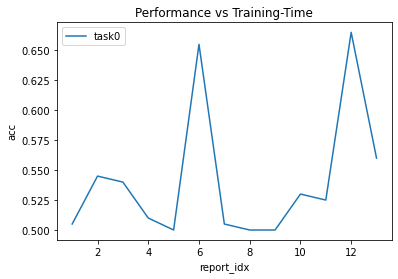

Training completed. Auto-saving to "ag-02-sentiment-classifcation-kor/". For loading the model, you can use `predictor = TextPredictor.load("ag-02-sentiment-classifcation-kor/")`


In [9]:
from autogluon.text import TextPredictor

predictor = TextPredictor(label='label', eval_metric='acc', path=save_path)
predictor.set_verbosity(2)
predictor.fit(train_data, presets='multi_cased_bert_base_fuse_late', time_limit=120)

<br>

## 2. Evaluation and Prediction

### Evaluation

`predictor.evaluation()`를 사용하여 평가를 쉽게 수행할 수 있으며, F1 score 등의 추가 metric도 지정 가능합니다.

In [10]:
test_score = predictor.evaluate(test_data, metrics=['acc', 'f1'])
print(test_score)

{'acc': 0.6796796796796797, 'f1': 0.7014925373134328}


### Prediction
`predictor.predict()`으로 예측을 수행할 수 있습니다.

In [34]:
sentence1 = "이 영화 너무너무 재미있어요. 인생 최고의 영화입니다. 최고!"
sentence2 = "평점 1점도 아깝습니다..비추"
predictions = predictor.predict({'document': [sentence1, sentence2]})
print('"Sentence":', sentence1, '"Predicted Sentiment":', predictions[0])
print('"Sentence":', sentence2, '"Predicted Sentiment":', predictions[1])

"Sentence": 이 영화 너무너무 재미있어요. 인생 최고의 영화입니다. 최고! "Predicted Sentiment": 1
"Sentence": 평점 1점도 아깝습니다..비추 "Predicted Sentiment": 0


### Extract Embeddings
훈련된 predictor를 사용하여 임베딩 벡터에 매핑하는 임베딩을 추출할 수도 있습니다.

In [35]:
embeddings = predictor.extract_embedding(test_data)
print(embeddings)

[[ 0.00364058  0.03059608 -0.08003689 ...  0.10889229  0.0908663
  -0.1842409 ]
 [-0.02480217 -0.01789573 -0.08753858 ...  0.11531632  0.08343364
  -0.17648585]
 [-0.00429124 -0.02888179  0.05131195 ...  0.07422637  0.10903466
  -0.15672252]
 ...
 [-0.03323803  0.00098329 -0.00266667 ...  0.07073754  0.07711349
  -0.162455  ]
 [ 0.00227197  0.01763633 -0.01963877 ...  0.07209975  0.04332367
  -0.12857531]
 [-0.02679621  0.02273615 -0.0377441  ...  0.06500638  0.10859583
  -0.18358707]]


TSNE를 사용하여 추출된 임베딩을 시각화합니다. 성능 향상을 위해서는 다국어 모델보다는 한국어 전용 모델로 훈련하는 것이 더 유리합니다.

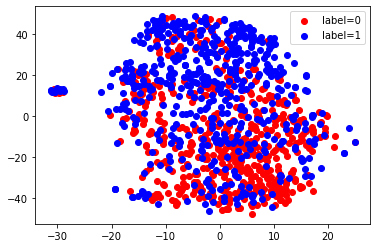

In [36]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, random_state=123).fit_transform(embeddings)
for val, color in [(0, 'red'), (1, 'blue')]:
    idx = (test_data['label'].to_numpy() == val).nonzero()
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], c=color, label=f'label={val}')
plt.legend(loc='best')